# Frontend

In [1]:
from __future__ import annotations
import math
import random
from pathlib import Path
import sys
from typing import Union

import librosa
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

sys.path.append(str(Path('.').absolute().parent/'src'))


def normalize(tensor):
    return (tensor - tensor.mean()) / tensor.std()


def fade(wave):
    fadein = np.linspace(0, 1, 160)
    fadeout = np.linspace(1, 0, 160)
    wave[:160] *= fadein
    wave[-160:] *= fadeout
    return wave


def pcolormesh(array, fig, ax):
    pcm = ax.pcolormesh(array, cmap='Reds')
    cbar = fig.colorbar(pcm, ax=ax)


def pcolormesh_symmetric(array, fig, ax):
    pcm = ax.pcolormesh(array, cmap='seismic')
    cbar = fig.colorbar(pcm, ax=ax)
    clim = np.max(np.abs(array)).item()
    pcm.set_clim(-clim, clim)

/Users/sky/Projects/auto-grbas/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Mel spectrogram

In [2]:
from models.nn.frontend.mel import MelSpectrogram
MelSpectrogram(
    features=["power", "ist_frq", "grp_dly"],
)

MelSpectrogram(
  fs=16000, num_filters=128, window_length=800, shift_length=160, f_min=0.0, f_max=None, num_fft=4000, window_name='hann', power_threshold=1e-06, features=('grp_dly', 'ist_frq', 'power'), 
  (mel_scale): MelScale()
  (compressor): ModuleDict(
    (grp_dly): PhaseDerivativeCompressor(num_filters=128, eps=1e-05, momentum=0.1, scaling=True, track_running_stats=True)
    (ist_frq): PhaseDerivativeCompressor(num_filters=128, eps=1e-05, momentum=0.1, scaling=True, track_running_stats=True)
    (power): PowerCompressor(threshold=1e-06)
  )
)

In [3]:
def plot(
    num_filters=128,
):
    ############################################################################
    ############################################################################
    ### Configuration
    ############################################################################
    ############################################################################
    fs = 16000
    features = ["power", "ist_frq", "grp_dly"]
    paths = {
        'Normal Voice': '../sample_audio/hidaka_normal.wav',
        'Rough Voice': '../sample_audio/hidaka_rough.wav',
        'Breathy Voice': '../sample_audio/hidaka_breathy.wav',
        'Strained Voice': '../sample_audio/hidaka_strained.wav',
        'Click': '../sample_audio/click.wav',
    }

    ############################################################################
    ############################################################################
    ### Calculation
    ############################################################################
    ############################################################################
    mel = MelSpectrogram(
        fs = fs,
        num_filters=num_filters,
        features=features,
    )
    print(mel)

    input = []
    for path in paths.values():
        wave = librosa.load(path, sr=16000, dtype=np.float32)[0]
        wave = normalize(torch.from_numpy(fade(wave))[None, None, :])
        input.append(wave)
    output = mel(input)

    fig, axes = plt.subplots(len(paths), 3, figsize=(25, len(paths)*5))
    for i, (title, o) in enumerate(zip(paths.keys(), output)):
        ax = axes[i,0]
        power = o[0,2].detach().numpy()
        pcolormesh(power, fig, ax)
        ax.set(title=f'{title}: power')

        ax = axes[i,1]
        ist_frq = o[0,1].detach().numpy()
        pcolormesh_symmetric(ist_frq, fig, ax)
        ax.set(title=f'{title}: instantaneous frequency')

        ax = axes[i,2]
        grp_dly = o[0,0].detach().numpy()
        pcolormesh_symmetric(grp_dly, fig, ax)
        ax.set(title=f'{title}: group delay')

MelSpectrogram(
  fs=16000, num_filters=128, window_length=800, shift_length=160, f_min=0.0, f_max=None, num_fft=4000, window_name='hann', power_threshold=1e-06, features=('grp_dly', 'ist_frq', 'power'), 
  (mel_scale): MelScale()
  (compressor): ModuleDict(
    (grp_dly): PhaseDerivativeCompressor(num_filters=128, eps=1e-05, momentum=0.1, scaling=True, track_running_stats=True)
    (ist_frq): PhaseDerivativeCompressor(num_filters=128, eps=1e-05, momentum=0.1, scaling=True, track_running_stats=True)
    (power): PowerCompressor(threshold=1e-06)
  )
)


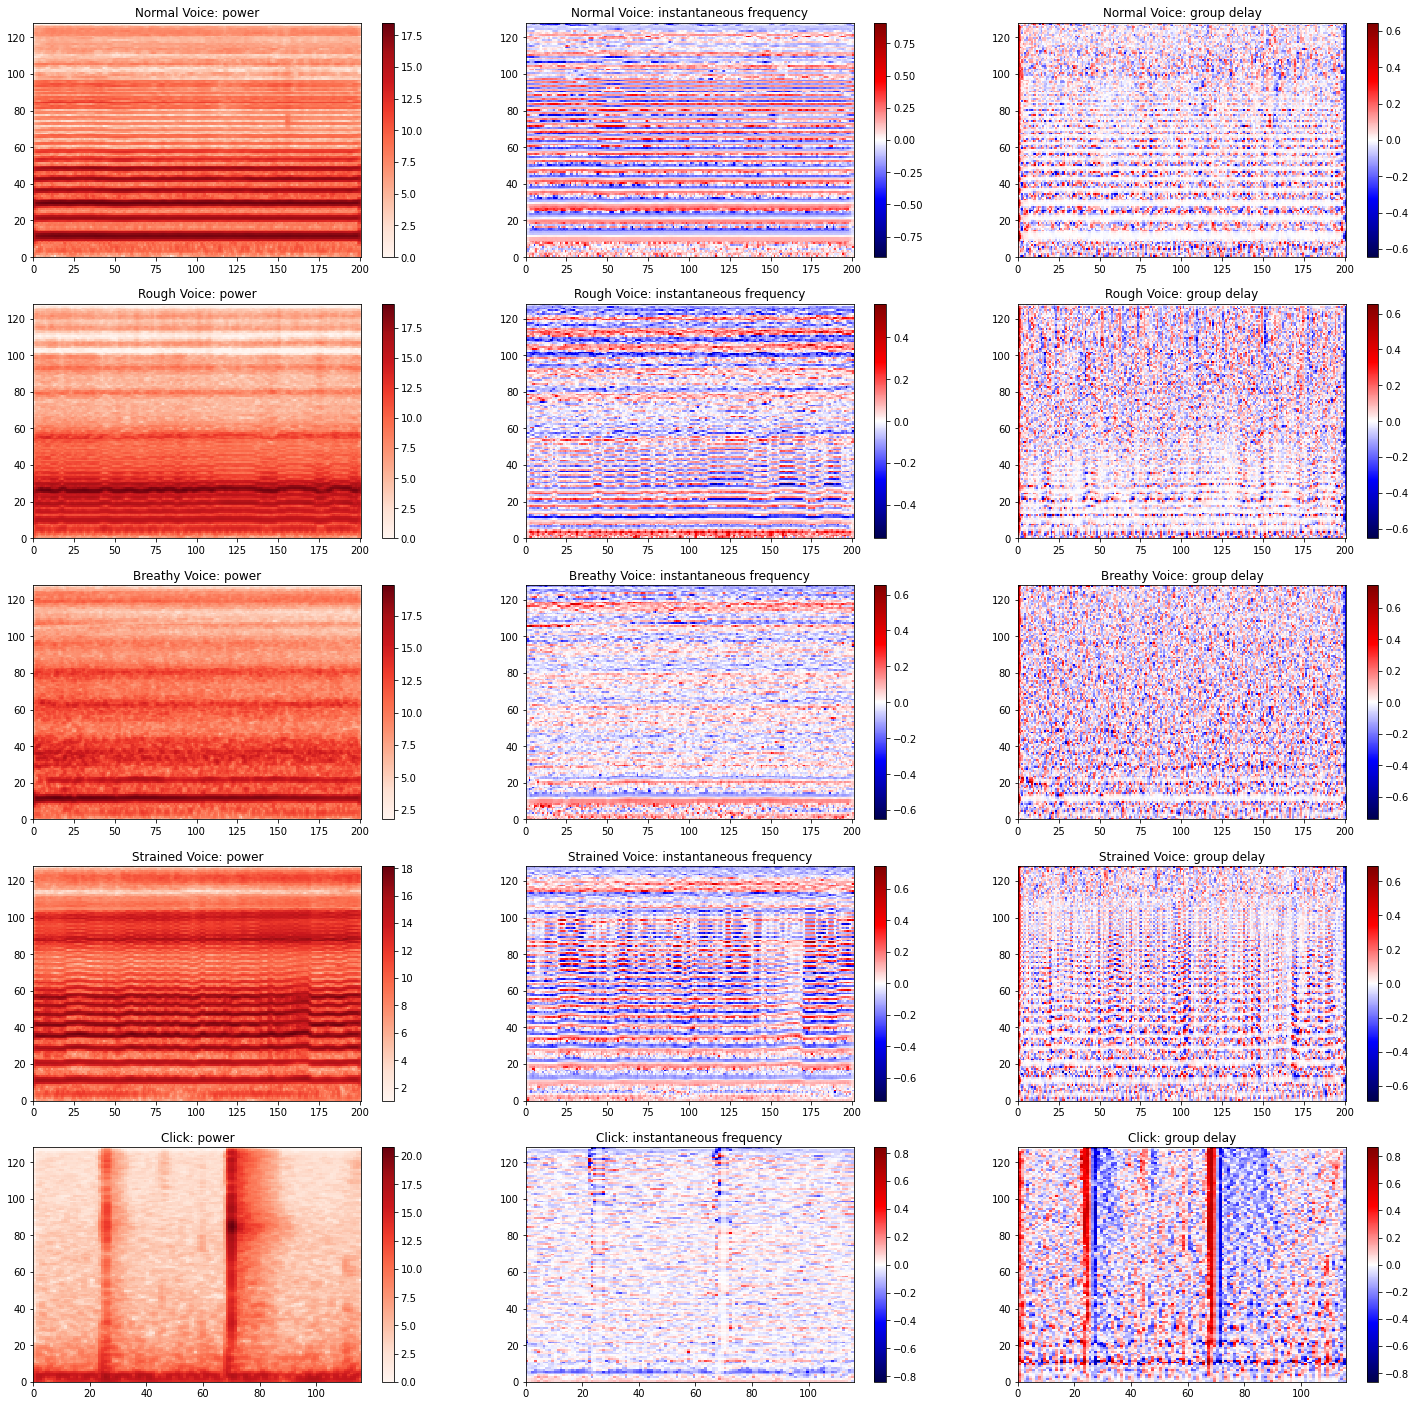

In [4]:
plot(
    num_filters=128,
)

## Full frontend

In [5]:
from models.nn.frontend import Frontend

Frontend()

Frontend(
  out_channels=1
  (tfr_calculator): MelSpectrogram(
    fs=16000, num_filters=128, window_length=800, shift_length=160, f_min=0.0, f_max=None, num_fft=4000, window_name='hann', power_threshold=1e-06, features=('power',), 
    (mel_scale): MelScale()
    (compressor): ModuleDict(
      (power): PowerCompressor(threshold=1e-06)
    )
  )
  (freq_mask): FrequencyMasking(mask_param=26, batch_iid_masks=True)
  (batch_norm_2d): VariableLengthBatchNorm2D(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [6]:
def plot(
    num_filters=128,
    freq_mask=False,
    training=True,
):
    ############################################################################
    ############################################################################
    ### Configuration
    ############################################################################
    ############################################################################
    fs = 16000
    features = ["power", "ist_frq", "grp_dly"]
    paths = {
        'Normal Voice': '../sample_audio/hidaka_normal.wav',
        'Rough Voice': '../sample_audio/hidaka_rough.wav',
        'Breathy Voice': '../sample_audio/hidaka_breathy.wav',
        'Strained Voice': '../sample_audio/hidaka_strained.wav',
        'Click': '../sample_audio/click.wav',
    }

    ############################################################################
    ############################################################################
    ### Calculation
    ############################################################################
    ############################################################################
    frontend = Frontend(
        fs=fs,
        num_filters=num_filters,
        features=features,
        freq_mask=freq_mask,
    )
    print(frontend)
    if not training:
        frontend.eval()

    input = []
    for path in paths.values():
        wave = librosa.load(path, sr=16000, dtype=np.float32)[0]
        wave = normalize(torch.from_numpy(fade(wave))[None, None, :])
        input.append(wave)
    output = frontend(input)

    fig, axes = plt.subplots(len(paths), 3, figsize=(25, len(paths)*5))
    for i, (title, o) in enumerate(zip(paths.keys(), output)):
        ax = axes[i,0]
        power = o[0,2].detach().numpy()
        pcolormesh(power, fig, ax)
        ax.set(title=f'{title}: power')

        ax = axes[i,1]
        ist_frq = o[0,1].detach().numpy()
        pcolormesh_symmetric(ist_frq, fig, ax)
        ax.set(title=f'{title}: instantaneous frequency')

        ax = axes[i,2]
        grp_dly = o[0,0].detach().numpy()
        pcolormesh_symmetric(grp_dly, fig, ax)
        ax.set(title=f'{title}: group delay')

Frontend(
  out_channels=3
  (tfr_calculator): MelSpectrogram(
    fs=16000, num_filters=128, window_length=800, shift_length=160, f_min=0.0, f_max=None, num_fft=4000, window_name='hann', power_threshold=1e-06, features=('grp_dly', 'ist_frq', 'power'), 
    (mel_scale): MelScale()
    (compressor): ModuleDict(
      (grp_dly): PhaseDerivativeCompressor(num_filters=128, eps=1e-05, momentum=0.1, scaling=True, track_running_stats=True)
      (ist_frq): PhaseDerivativeCompressor(num_filters=128, eps=1e-05, momentum=0.1, scaling=True, track_running_stats=True)
      (power): PowerCompressor(threshold=1e-06)
    )
  )
  (freq_mask): FrequencyMasking(mask_param=26, batch_iid_masks=True)
  (batch_norm_2d): VariableLengthBatchNorm2D(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


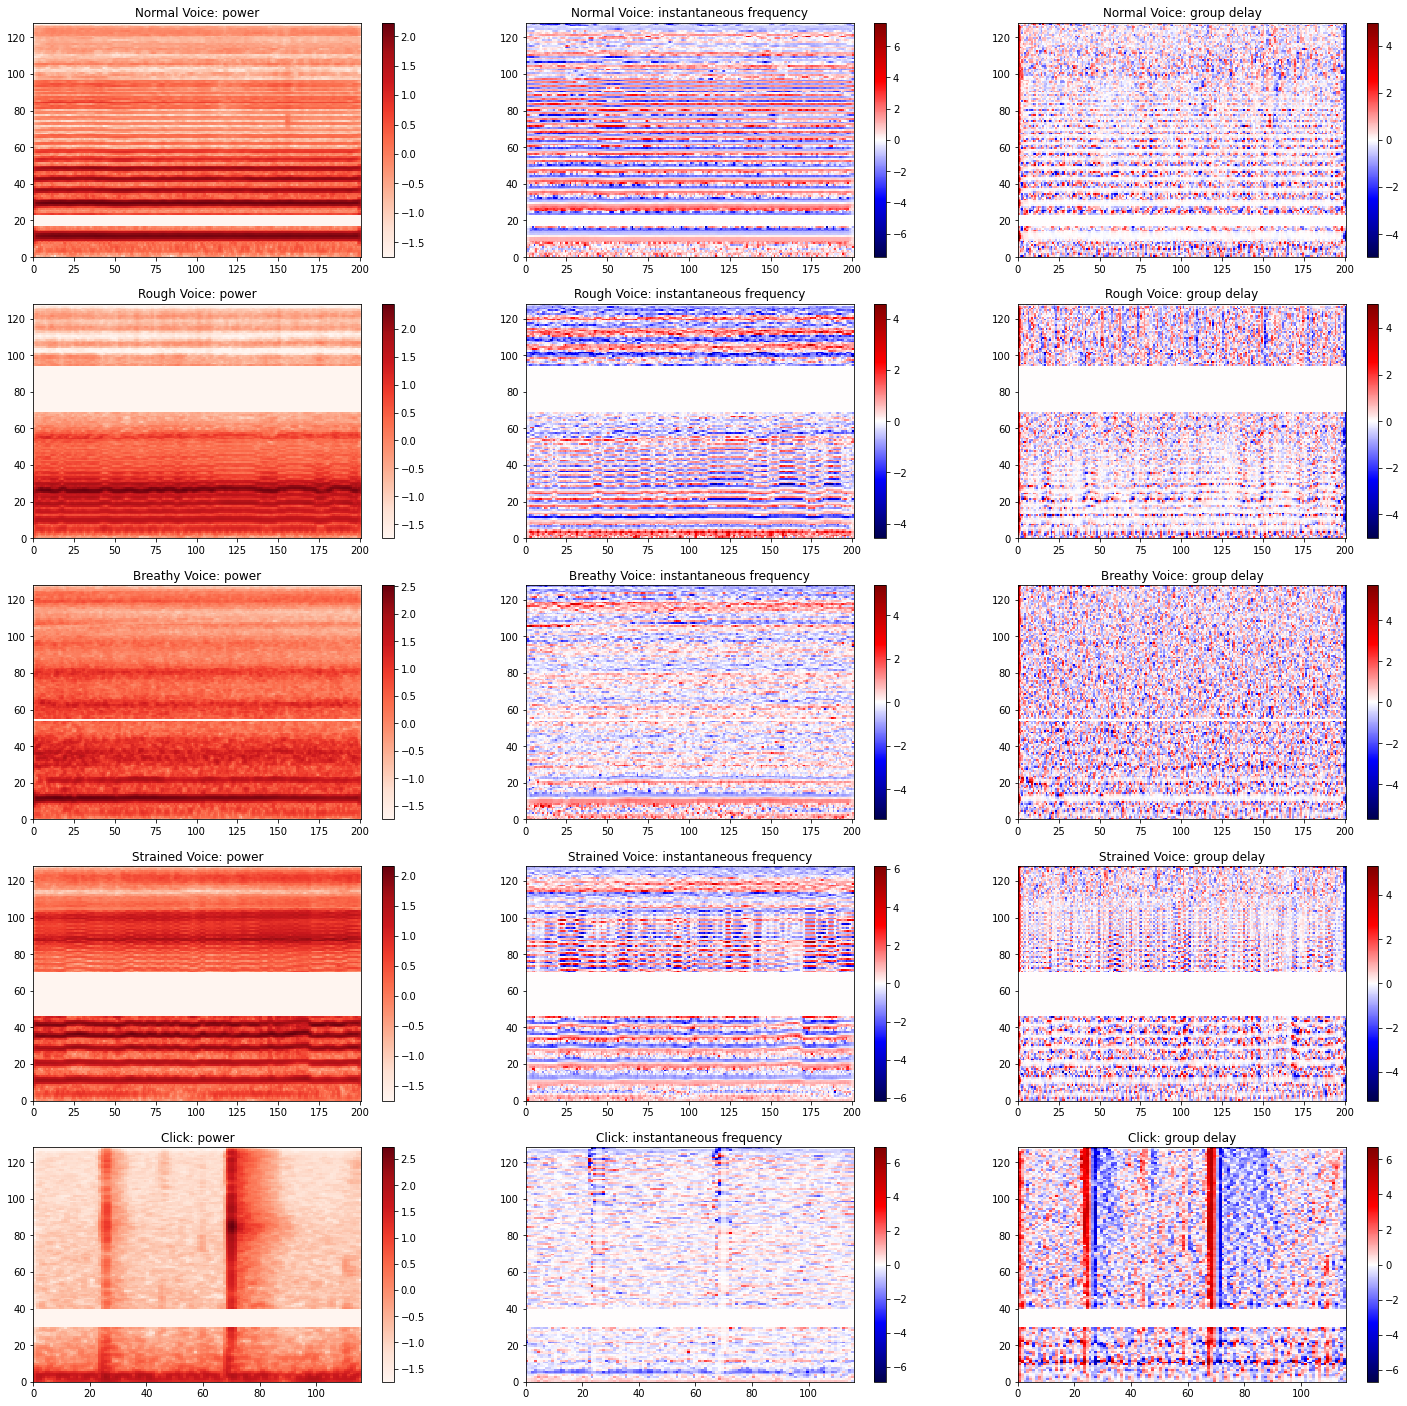

In [7]:
plot(
    num_filters=128,
    freq_mask=True,
    training=True,
)

***

*End*